# Calculating the difference between CDIP buoy data (actual heights) and Smartfin data (expected heights) for the month with most data points available

In [1]:
#Ben Werb 07/09/2020
#E4E

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from pandas import DataFrame
from statsmodels.stats.weightstats import ttest_ind
from scipy import stats
import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests


from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added
import statistics #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline

## Load in expected height data from Scripps_Final_Double_Integral_Analysis

In [2]:
plot_df = pd.read_csv('plot_df.csv')
print(plot_df.head())

   Unnamed: 0                             UTC        Date  Actual Height  \
0          38  2017-05-20T00:40:00.0870+00:00  2017-05-20       0.679704   
1          39  2017-05-20T01:10:00.2870+00:00  2017-05-20       0.749808   
2          26  2017-05-31T19:10:00.1080+00:00  2017-05-31       0.810768   
3          27  2017-05-31T19:40:00.2080+00:00  2017-05-31       0.810768   
4          68  2017-06-16T21:10:00.1970+00:00  2017-06-16       0.841248   

   Expected Height  
0         0.906603  
1         0.908520  
2         0.874762  
3         0.725721  
4         0.824378  


## I want to find the year/month with the most data points to work with

In [3]:
#Creates list of UTC times, dates, actual and expected heights from calculated data in Scripps Double Integral Analysis
Expected_Heights_df = DataFrame(plot_df, columns= ['UTC', 'Date', 'Expected Height', 'Actual Height'])
print(Expected_Heights_df.head())

                              UTC        Date  Expected Height  Actual Height
0  2017-05-20T00:40:00.0870+00:00  2017-05-20         0.906603       0.679704
1  2017-05-20T01:10:00.2870+00:00  2017-05-20         0.908520       0.749808
2  2017-05-31T19:10:00.1080+00:00  2017-05-31         0.874762       0.810768
3  2017-05-31T19:40:00.2080+00:00  2017-05-31         0.725721       0.810768
4  2017-06-16T21:10:00.1970+00:00  2017-06-16         0.824378       0.841248


In [4]:
Expected_Heights_2017_df = Expected_Heights_df[Expected_Heights_df['Date'].str.contains('2017')]
Expected_Heights_2018_df = Expected_Heights_df[Expected_Heights_df['Date'].str.contains('2018')]
Expected_Heights_2019_df = Expected_Heights_df[Expected_Heights_df['Date'].str.contains('2019')]
print(str('Data points from 2017: ') + str(len(Expected_Heights_2017_df)))
print(str('Data points from 2018: ') + str(len(Expected_Heights_2018_df)))
print(str('Data points from 2019: ') + str(len(Expected_Heights_2019_df)))

Data points from 2017: 74
Data points from 2018: 33
Data points from 2019: 9


In [5]:
Heights = []

for i in range(0, 10):
    Heights.append(Expected_Heights_2017_df[Expected_Heights_2017_df['Date'].str.contains('-0'+str(i)+'-')])
    
for i in range(10,13):
        Heights.append(Expected_Heights_2017_df[Expected_Heights_2017_df['Date'].str.contains('-'+str(i)+'-')])

print('Surf sessions by month:')
for i in range(1,13):
     print(str(i) + str(': ') + str(len(Heights[i])))

Surf sessions by month:
1: 0
2: 0
3: 0
4: 0
5: 4
6: 29
7: 5
8: 11
9: 11
10: 10
11: 0
12: 4


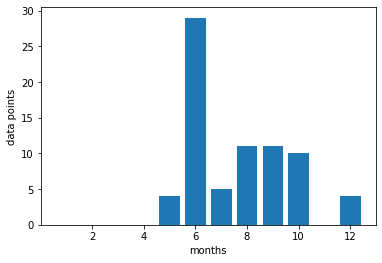

In [26]:
x = [1,2,3,4,5,6,7,8,9,10,11,12]
y = [0,0,0,0,4,29,5,11,11,10,0,4]
plt.bar(x,y)
plt.xlabel('months')
plt.ylabel('data points')
plt.show()

In [7]:
month = int(input('month:'))

month:6


In [8]:
Height_df = Heights[month]
Height_df = Height_df.drop_duplicates(subset='Expected Height', keep="first")
Height_df = Height_df[Height_df['Expected Height'] <= 1.7] 
print(Height_df.head())
print(len(Height_df))

                              UTC        Date  Expected Height  Actual Height
4  2017-06-16T21:10:00.1970+00:00  2017-06-16         0.824378       0.841248
5  2017-06-16T21:40:00.2680+00:00  2017-06-16         0.939788       0.920496
6  2017-06-18T23:10:00.1900+00:00  2017-06-18         1.016650       0.899160
7  2017-06-18T23:40:00.4410+00:00  2017-06-18         1.163987       1.078992
8  2017-06-22T19:40:00.1790+00:00  2017-06-22         1.072348       0.929640
20


## Running T-tests on June 2017 data to determine how accurate it is compared to CDIP buoy data

Null Hypothesis: The monthly buoy wave height average is the same as the Smartfin's

Alternate Hypothesis: The monthly averages are different

In [9]:
Expected_Heights_06_2017 = Height_df['Expected Height'].to_numpy()
Actual_Heights_06_2017 = Height_df['Actual Height'].to_numpy()
test1 = stats.ttest_ind(Expected_Heights_06_2017, Actual_Heights_06_2017)
test2 = stats.ttest_1samp(Expected_Heights_06_2017, Actual_Heights_06_2017)
#I do not understand the results of test2
print('T-score is ' + str(test1[0]) + ' with ' + str(100 - test1[1]*100) + '% ' + 'confidence')

T-score is 1.9759123263213314 with 94.45415120533751% confidence


## Plot data together to see differences
CDIP data is plotted only from dates that match the Smartfin database

Buoy Mean is: 0.821436
Smartfin Mean is: 0.9274999034411355


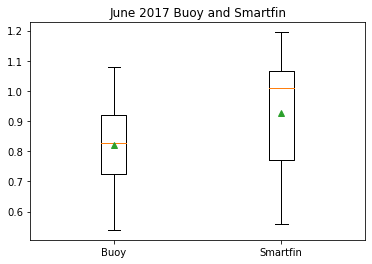

In [10]:
plt.boxplot([Actual_Heights_06_2017, Expected_Heights_06_2017], labels = ['Buoy', 'Smartfin'], showmeans=True)
plt.title('June 2017 Buoy and Smartfin')
print('Buoy Mean is: ' + str(np.mean(Actual_Heights_06_2017)))
print('Smartfin Mean is: ' + str(np.mean(Expected_Heights_06_2017)))

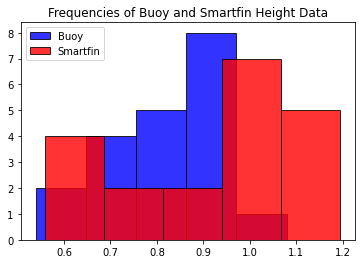

In [11]:
plt.hist(Actual_Heights_06_2017, color = 'blue', edgecolor = 'black', bins=5, alpha=.8)
plt.hist(Expected_Heights_06_2017, color = 'red', edgecolor = 'black', bins=5, alpha=.8)
#ax.hist(Actual_Heights_06_2017, bins, weights=Actual_Heights_06_2017)
plt.legend(['Buoy', 'Smartfin'])
plt.title('Frequencies of Buoy and Smartfin Height Data')
plt.show()

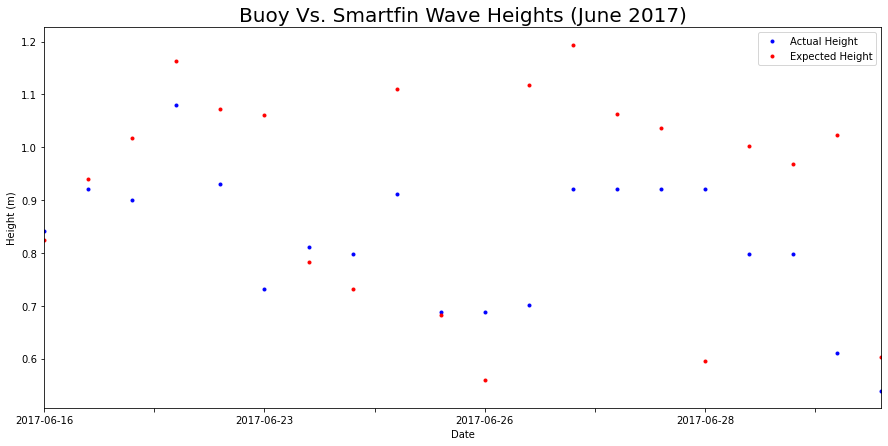

In [12]:
# data_to_plot = DataFrame(plot_df, columns= ['UTC', 'Date', 'Expected Height', 'Actual Height'])
# June = data_to_plot[data_to_plot['UTC'].str.contains('2017-06-')]
from scipy.stats import linregress
ax = plt.gca()
Height_df.plot(x='Date', y='Actual Height', ax=ax, style='.', figsize=(15,7), color='blue')
Height_df.plot(x='Date', y='Expected Height', color='red', ax=ax, style='.')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Height (m)')
plt.title('Buoy Vs. Smartfin Wave Heights (June 2017)', size=20)
plt.show()

## Buoy Wave Height Prediction for June

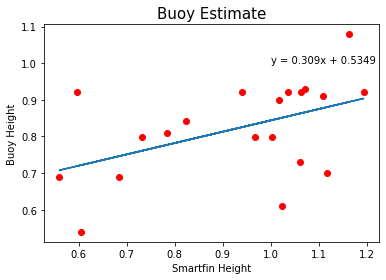

Prediction is: y = 0.309x + 0.5349


In [13]:
x = Height_df['Expected Height']#.values.reshape(-1,1)
y = Height_df['Actual Height']#.values.reshape(-1,1)
# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(x,y)  # perform linear regression
# y_pred = linear_regressor.predict(x)  # make predictions

(m,b) = np.polyfit(x ,y ,1)
yp = np.polyval([m,b],x)
equation = 'y = ' + str(round(m,4)) + 'x' ' + ' + str(round(b,4))
plt.scatter(x,y, color='red')
plt.plot(x,yp)
plt.text(1,1, equation)

# plt.scatter(x, y)
# plt.plot(x, y_pred, color='red')
plt.xlabel('Smartfin Height')
plt.ylabel('Buoy Height')
plt.title('Buoy Estimate', size=15)
plt.show()
print('Prediction is: ' + str(equation))

In [14]:
Expected = float(input('Expected Wave Height is: '))
Prediction = ((Expected * .309) + .5349)
print('Smartfin Wave Height Prediction is: ' + str(Prediction))

Expected Wave Height is: .8
Smartfin Wave Height Prediction is: 0.7821
